# CS181 Final Project

_Author: Grace Le_

_Date: May 18th, 2021_

## Data from Spotify API

The data for this project comes from Spotify, https://www.spotify.com. This provider has an API that allows us to retrieve users' following artists and related artists, which we will focus on in the data exploration and analysis step. 

To have the end user approve our app for access to their Spotify data and features, or to have our app fetch data from Spotify, we need to authorize our application via User Authorization. Spotify, as well as the user, grant our app permission to access and modify the user’s own data. 

__Set up: Importing Libraries__

In [1]:
import os
import sys
import json
import requests

def add_modules():
    """
    Starting at the current directory and proceeding up the file system
    tree, search for a directory named `modules`.  If found, and if not
    already there, add to the Python module search path.
    Params: None
    
    Return: None
    """
    directory = "."
    levels = 0
    while not os.path.isdir(os.path.join(directory, "modules")) and \
          levels < 5:
        directory = os.path.join(directory, "..")
        levels += 1
    module_path = os.path.abspath(os.path.join(directory, "modules"))
    if os.path.isdir(module_path):
        if not module_path in sys.path:
            sys.path.append(module_path)

add_modules()
import util
datadir = util.resolve_dir(".")

import importlib
import webbrowser
import base64
from datetime import datetime, timedelta
from requests.auth import HTTPBasicAuth

ModuleNotFoundError: ignored

## User Authorization

### Step 1: Request authorization from user

In this step, our application sends a request to the Spotify Accounts service and user to grant us access to their data.

* First of all, we need to create a `creds.json` file in our current directory to store our dictionary of credentials and then read the data to a variable `creds`. The data must contain a `client_id`, a `client_secret`, a `redirect_uri`, a space-separated list of `scope`, a `response_type` set to `code`, and an optional but recommended `state` that provides protection against attacks. `state` can be generated randomly as a string and then updated to the credential file. 

* Next, we __build a url request__ that asks user to authorize access with an authorization code that can be exchanged for an access token embedded in the redirected uri. Please __update__ the __code__ in the credential file to continue. 

In [ ]:
creds = util.read_creds("spotify")

In [ ]:
def state_generation(keycreds, creds_dict):
    """
    Generate a random string for 'state' and update credentials file. 
    Params:
        keycreds: The key for the credentials.
        creds_dict: The credential from creds.json file.
    Return: None
    """
    state = util.random_string()
    creds['state'] = state
    creds_dict = util.update_creds(keycreds, creds_dict)
    return None

In [ ]:
def authorization(keycreds, creds_dict): 
    """
    Build a url request that asks user to authorize access within the scopes 
            and then returns to the redirect_uri with a code for access. 
    Params:
        keycreds: The key for the credentials.
        creds_dict: The credential from creds.json file.
    Return the url request. 
    """
    state_generation(keycreds, creds_dict)
    paramsD = {
        'client_id' : creds_dict['client-id'],
        'client_secret' : creds_dict['client-secret'],
        'redirect_uri': creds_dict['redirect-url'],
        'state': creds_dict['state'],
        'scope': creds_dict['scope'],
        'response_type': 'code'
    }
    url = util.buildURL("/authorize", "accounts.spotify.com")
    session = requests.Session()
    req = requests.Request('GET', url, params=paramsD)
    prepped = session.prepare_request(req)
    user_url = prepped.url
    return user_url

In [ ]:
authorization("spotify", creds)

'https://accounts.spotify.com/authorize?client_id=9cf62620e57c4e7e87e1a2a0f29cad12&client_secret=323e3d0e04064e7597ffdc4e2c7e0364&redirect_uri=https%3A%2F%2Fcaileighmarshall.github.io%2Fcs181project%2F&state=3DVZJKJV&scope=playlist-read-private+playlist-read-collaborative+user-follow-read+playlist-modify-private+user-read-email+user-read-private+app-remote-control+streaming+user-follow-modify+user-modify-playback-state+user-library-read+user-library-modify+playlist-modify-public+user-read-playback-state+user-read-currently-playing+user-read-recently-played+user-read-playback-position+user-top-read&response_type=code'

### Step 2: Request Refresh and Access Token

When the authorization code has been received, we need to exchange it with an access token by making a POST request to the Spotify Accounts service, this time to its /api/token endpoint.

* The body of this POST request must contain the following parameters encoded in ´application/x-www-form-urlencoded': a `grant_type` set to `authorization_code`, a `code` from the previous step, and our `redirect_uri`. 

* The header of this POST request contains a `Authorization` key that maps to a base 64 encoded string that contains the client ID and client secret key. 

The functions below construct the body and the header parameters for the request, then make a post request to the /api/token endpoint for the refresh and access token. 

In [ ]:
def token_body_params(keycreds): 
    """
    Create a body parameter for the post request based on the credentials from the credential file. 
    Params:
        creds_dict: The credential from creds.json file.
    Return the body parameter.
    """
    creds_dict = util.read_creds(keycreds)
    body_params = {
        'grant_type': 'authorization_code', 
        'code': creds_dict['code'],
        'redirect_uri': creds_dict['redirect-url']
    }
    return body_params

In [ ]:
def client_creds_b64(creds_dict):
    """
    Create a header parameter based on client id and client secret in the credential file. 
    Params:
        creds_dict: The credential from creds.json file.
    Return the header parameter.
    """
    client_creds = f"{creds_dict['client-id']}:{creds_dict['client-secret']}"
    client_creds_b64 = base64.b64encode(client_creds.encode())
    header_params = {
        "Authorization": f"Basic {client_creds_b64.decode()}" 
    }
    return header_params

In [ ]:
def token_dict_retrieve(keycreds, creds_dict):
    """
    Get a token dictionary that contains refresh and access tokens 
            by making a post request to the /api/token endpoint and reading the response as a json object. 
    Params:
        keycreds: The key for the credentials.
        creds_dict: The credential from creds.json file.
    Return the token dictionary.
    """
    header_params = client_creds_b64(creds_dict)
    body_params = token_body_params(keycreds)
    
    url = util.buildURL("/api/token", "accounts.spotify.com")
    response = requests.post(url, data=body_params, headers=header_params)
    if response.status_code != 200:
        print("Error.  Status code:", response.status_code)
        print(response.text)
        
    tokenD = response.json()
    return tokenD

tokenD = token_dict_retrieve("spotify", creds)

In [ ]:
def save_token_json(tokenD, keycreds, creds_dict): 
    """
    Updating the refresh and access token to the credential file. 
    Params:
        tokenD: The token dictionary returned from the post request. 
        keycreds: The key for the credentials.
        creds_dict: the credential file.
    Return: None.
    """
    creds_dict['token'] = tokenD['access_token']
    creds_dict['refresh'] = tokenD['refresh_token']
    creds_dict['scope'] = tokenD['scope']
    expiration = datetime.now() + timedelta(seconds=tokenD['expires_in'])
    creds_dict['expires'] = str(expiration)
    creds = util.update_creds(keycreds, creds_dict)
    return None

### Step 3: Use the access token to access the Spotify Web API

The access token allows you to make requests to the Spotify Web API on behalf of the user. This step can be done by doing a get request to the data endpoint `/v1/me/top/artists` to access users's artists, with a header parameter based on the token from the previous post request.

Given the information about users' artists, we also used the API to obtain information about the related artists. Each artist has values corresponding to four categories: name, followers, popularity, and their genres. The popularity metric is one invented and maintained by Spotify and incorporates a number of factors to get the popularity scaler (int) value in scale 100.

In [ ]:
def token_authHeader(keycreds, creds_dict): 
    """
    Constructing a authorization header parameter for the get request. 
    Params:
        keycreds: The key for the credentials.
        creds_dict: the credential file.
    Return: the header parameter.
    """
    token = creds_dict['token']
    authHeader = "Bearer {}".format(token)
    headerD = {"Authorization": authHeader}
    return headerD

In [ ]:
def get_artist(keycreds, creds_dict):
    """
    Making a get request to /v1/me/top/artists that contains user's followed artists. 
    Params:
        keycreds: The key for the credentials.
        creds_dict: the credential file.
    Return: the response json object that contains user's foll.
    """
    authHeaders = token_authHeader(keycreds, creds_dict)
    url = util.buildURL("/v1/me/top/artists", "api.spotify.com")
    paramsD = {'limit':50}
    
    resp = requests.get(url, headers=authHeaders, params=paramsD)
    if resp.status_code != 200:
        print("Error.  Status code:", resp.status_code)
    return resp.json()

In [ ]:
def get_artist_related(artist_id, keycreds, creds_dict):
    """
    Making a get request to /v1/me/top/artists that contains an artist's related artists. 
    Params:
        artist_id: The id for the intital artist. 
        keycreds: The key for the credentials.
        creds_dict: the credential file.
    Return: the response json object that contains an artist's related artists.
    """
    authHeaders = token_authHeader(keycreds, creds_dict)
    url = util.buildURL(f"/v1/artists/{artist_id}/related-artists", "api.spotify.com")
    resp = requests.get(url, headers=authHeaders)
    if resp.status_code != 200:
        print("Error.  Status code:", resp.status_code)
    return resp.json()

### Step 4: Request a refreshed access token

This step makes a get request to the token endpoint of the Spotify Accounts service to get a refreshed access token. In this step, the `grant_type` in the body parameter should be set to `refresh_token`.

In [ ]:
def refresh_token(keycreds, creds_dict):
    """
    Get a refreshed token dictionary that contains refresh and access tokens 
            by making a post request to the /api/token endpoint and reading the response as a json object. 
    Params:
        keycreds: The key for the credentials.
        creds_dict: The credential from creds.json file.
    Return the refreshed token dictionary.
    """
    creds = util.read_creds(keycreds)
    assert 'token' in creds
    assert 'refresh' in creds

    location = "accounts.spotify.com"
    resource_path = "/api/token"
    url = util.buildURL(resource_path, location)

    auth = HTTPBasicAuth(creds_dict['client-id'], creds_dict['client-secret'])
    bodyD = {
        'grant_type': 'refresh_token',
        'refresh_token': creds['refresh']
    }

    response = requests.post(url, auth=auth, data=bodyD)
    if response.status_code != 200:
        print("Error.  Status code:", response.status_code)
        print(response.text)
    
    return response.json()

In [ ]:
def save_refresh_token(keycreds, creds_dict):
    """
    Updating the refresh and access token to the credential file. 
    Params:
        keycreds: The key for the credentials.
        creds_dict: the credential file.
    Return: None.
    """
    tokenD = refresh_token(keycreds, creds_dict)
    creds_dict['token'] = tokenD['access_token']
    creds_dict['scope'] = tokenD['scope']
    expiration = datetime.now() + timedelta(seconds=tokenD['expires_in'])
    creds_dict['expires'] = str(expiration)
    creds_dict = util.update_creds("spotify", creds_dict)
    return None

save_refresh_token("spotify", creds)

## Fetch data from Spotify API

In this step, we want to iterate over all users' keys we got from our friends in the previous steps and use them to get data about Spotify artists. 

* First, we construct a List of Dictionary that accumulates all the information about the artist objects fetched from the user's artists Spotify endpoint. 

* Next, we construct a List of Dictionary of tidy information based on the artist objects. These dictionaries should only contain information about the artist's id, name, followers, popularity, and genres. 

* Then, we tidy the artist's related artists's information from the objects fetched get request previously defined. This is stored in a List of Dictionary. We use a random.choice function to get  only 50 artists from the users' data and then get their related artists. 

* Having the users' artists and related ones, we concatenate the two lists of dictionary together to build a pandas data frame. The lists can contain duplicates as well as missing values, so the pandas table needs to address those values. 

In [ ]:
def accumulate_artists(keycreds, cred_dict):
    """
    Accumulate all users' artists' data. 
    Params:
        keycreds: The key for the credentials.
        creds_dict: the credential file.
    Return: List of Dictionary of artist objects.
    """
    artist_obj_LoD = []
    keys = []
    with open("keys.json", "r") as keys_file: 
        keys_D = json.load(keys_file)
        for user in keys_D:
            refresh = keys_D[user]
            keys.append(refresh) 
        for key in keys:
            creds = util.read_creds("spotify")
            creds['refresh'] = key
            refresh_token_D = refresh_token(keycreds, creds)
            save_refresh_token(keycreds, creds)
            artist_D = get_artist(keycreds, creds)
            artist_obj_LoD.append(artist_D)
    return artist_obj_LoD

artist_obj_LoD = accumulate_artists("spotify", creds)

In [ ]:
def generate_artist_LoD(key, artist_obj_LoD):
    """
    Generate a List of Dictionary of all users' artists' tidy data. 
    Params:
        keycreds: The key for the credentials.
        creds_dict: the credential file.
    Return: List of Dictionary of artist's tidy information.
    """
    LoD = []
    for artist_dict in artist_obj_LoD:
        items = artist_dict[key]
        for item in items:
            itemDict = {}
            itemDict['id'] = item['id']
            itemDict['name'] = item['name']
            if len(item['genres']) != 0:
                itemDict['genre'] = []
                for genre in item['genres']:
                    itemDict['genre'].append(genre)
            itemDict['followers'] = item['followers']['total']
            itemDict['name'] = item['name']
            itemDict['pop'] = item['popularity']
            LoD.append(itemDict)
    return LoD

In [ ]:
import random
def generate_related_artist_LoD(key, artist_LoD, keycreds, cred_dict):
    """
    Accumulate all users' artists' related artists' data. 
    Params:
        keycreds: The key for the credentials.
        creds_dict: the credential file.
    Return: List of Dictionary of related artists' tidy data.
    """
    LoD = []
    for index in range(50):
        artist_D = random.choice(artist_LoD)
        artist_id = artist_D['id']
        related_artist_D = get_artist_related(artist_id, keycreds, cred_dict)
        LoD.append(related_artist_D)
    related_artist_LoD = generate_artist_LoD(key, LoD)
    return related_artist_LoD

In [ ]:
def concat_artist_LoD():
    """
    Concatenate two lists. 
    Params: None
    Return: concatenated List of Dictionary of all artists.
    """
    artist_LoD = generate_artist_LoD('items', artist_obj_LoD)
    related_artist_LoD = generate_related_artist_LoD('artists', artist_LoD, "spotify", creds)
    for artist_D in artist_LoD:
        related_artist_LoD.append(artist_D)
    return related_artist_LoD

In [ ]:
all_artists_LoD = concat_artist_LoD()

In [ ]:
import pandas as pd
def build_table(LoD):
    """
    Build table from the List of Dictionary. 
    Param: LoD: List of Dictionary of all artists' tidy data. 
    Return: The pandas data frame of all artists.
    """
    df = pd.DataFrame(LoD)
    df.drop_duplicates('id', inplace=True)
    df.dropna(inplace=True)
    return df

In [ ]:
artists_df = build_table(all_artists_LoD)

In [ ]:
artists_df.head(5)

,id,name,genre,followers,pop
0,3BiFZY6zbND5L3MEM6niE6,Emapea,"[chillhop, jazz boom bap, lo-fi jazzhop]",19418,51
1,39ZQx0618UYVBgGTDOJ2ds,FloFilz,"[chillhop, focus beats, jazz boom bap, lo-fi b...",49501,60
2,6x5HLaMcoxaULXpgN0NJbb,Flughand,"[chillhop, focus beats, jazz boom bap, lo-fi b...",29011,58
3,44insiIQApkRaCMIbuaISJ,Joey Pecoraro,"[chillhop, lo-fi beats]",107657,63
4,6M6LWvHKgBle8SUtSpq6SU,iamalex,"[chillhop, lo-fi beats]",11223,59


## Normalize Dataset

The current Data Frame is containing information about the artists' five values: `id`, `name`, `genre`, `followers`, `pop`. 

**Functional Dependencies:**

* id --> name, followers, pop
* id --> genre

Therefore, in order to have a tidy dataset, we have to split the data frame into two tables corresponding to each functional dependency. The first table contains information about name, followers, and poppularity. The second table contains the combination of id and genre. 

In [ ]:
def artists_genres_tables(artists_df):
    """
    Construct artists - genres table from the original dataframe. 
    Param: artists_df: original dataframe
    Return: artists - genres table
    """
    artists_genres = artists_df[['id', 'genre']].copy()
    artists_genres.dropna(inplace=True)
    LoL = []
    for index in range(len(artists_genres)):
        for value in artists_genres['genre'].iloc[index]:
            L = []
            L.append(artists_genres['id'].iloc[index])
            L.append(value)
            LoL.append(L)
    artists_genres_df = pd.DataFrame(LoL, columns=['id','genre'])
    return artists_genres_df

In [ ]:
artists_genres_df = artists_genres_tables(artists_df)

In [ ]:
artists_tidy_df = artists_df.drop(['genre'], axis=1)

In [ ]:
def export_to_csv(artists_df):
    """
    Export the two splitted data frames from the original dataframe to csv files. 
    Param: artists_df: original dataframe
    Return: None
    """
    artists_genres_df = artists_genres_tables(artists_df)
    artists_df = artists_df.drop(['genre'], axis=1)
    artists_df.to_csv("artists.csv", index=False)
    artists_genres_df.to_csv("artists_genres.csv", index=False)
    return None

In [ ]:
export_to_csv(artists_df)

## Data from Billboard Website

The data for this project comes from the Billboard website. We use a Python package called billboard.py that has up-to-date data from the Billboard website.

__Set up: Importing Libraries__

In [ ]:
#pip install billboard.py 
import billboard

### Step 1: Get the data

In this step, we start off by getting the data of two charts: "Hot 100" and "Digital Song Sales".

In [ ]:
def get_chart(chartname):
    """
    Get the chart data
    
    Params: 
        chartname: Name of the wanted chart
        
    Return: Chart data
    """
    
    chart = billboard.ChartData(chartname) #get chart data
    return chart

hot100 = get_chart('hot-100') #get 'Hot 100' chart
songsales = get_chart('digital-song-sales') #get 'Digital Song Sales' chart

### Step 2: Put the data into data frames

* First of all, we make a DoL for each of the chart with data such as song's title, artist, rank, peak position, position last week, weeks on chart, and new to chart.

* Next, we use pandas to build the data frames and export the clean data frames to csv files.

In [ ]:
def process_chart(chart):
    """
    Generate a dictionary to store the chart's data
    
    Params:
        chart: The chart data from previous step
        
    Return: A dictionary of lists with data of the chart
    """
    
    chartD = {} #create an empty dictionary
    
    #Create multiple empty lists so that we can build a DoL later
    title = []
    artist = []
    rank = []
    peakPos = []
    lastPos = []
    weeks = []
    isNew = []
    
    #Use a for loop to get and append data to lists
    for i in range(len(chart)):
        title.append(chart[i].title) #get song's title
        artist.append(chart[i].artist) #name of artist
        rank.append(chart[i].rank) #get song's current rank
        peakPos.append(chart[i].peakPos) #track's peak position on the chart as of the chart date
        lastPos.append(chart[i].lastPos) #track's position the previous week
        weeks.append(chart[i].weeks) #number of weeks that track has been on the chart
        isNew.append(chart[i].isNew) #whether track is new to the chart or not
    
    #Build DoL
    chartD['Rank'] = rank
    chartD['Song Title'] = title
    chartD['Artist'] = artist
    chartD['New To Chart'] = isNew
    chartD['Peak Position'] = peakPos
    chartD['Position Last Week'] = lastPos
    chartD['Weeks On Chart'] = weeks
    return chartD

hot100D = process_chart(hot100)
songsalesD = process_chart(songsales)

In [ ]:
def build_df(chartD):
    """
    Build a data frame from the DoL
    
    Params: 
        chartD: A DoL with chart's data
        
    Return: A data frame for each chart
    """
    
    df = pd.DataFrame(chartD) #build data frame
    df = df.set_index('Rank') #set data frame's index
    return df

In [ ]:
hot100DF = build_df(hot100D)
hot100DF.head(5) #show the first 5 rows of data frame

,Song Title,Artist,New To Chart,Peak Position,Position Last Week,Weeks On Chart
Rank,,,,,,
1,Save Your Tears,The Weeknd & Ariana Grande,False,1,1,21
2,Leave The Door Open,Silk Sonic (Bruno Mars & Anderson .Paak),False,1,2,9
3,Peaches,Justin Bieber Featuring Daniel Caesar & Giveon,False,1,3,7
4,Levitating,Dua Lipa Featuring DaBaby,False,4,5,31
5,Kiss Me More,Doja Cat Featuring SZA,False,5,6,4


Functional Dependency: 

Song Title -> Rank, Artist, New To Chart, Peak Position, Position Last Week, Weeks On Chart

In [ ]:
songsalesDF = build_df(songsalesD)
songsalesDF.head(5) #show the first 5 rows of data frame

,Song Title,Artist,New To Chart,Peak Position,Position Last Week,Weeks On Chart
Rank,,,,,,
1,Astronaut In The Ocean,Masked Wolf,False,1,2,12
2,Levitating,Dua Lipa Featuring DaBaby,False,2,4,32
3,Leave The Door Open,Silk Sonic (Bruno Mars & Anderson .Paak),False,2,3,9
4,Save Your Tears,The Weeknd & Ariana Grande,False,1,1,18
5,Without You,The Kid LAROI & Miley Cyrus,False,5,50,7


Functional Dependency: 

Song Title -> Rank, Artist, New To Chart, Peak Position, Position Last Week, Weeks On Chart

In [ ]:
def to_csv():
    """
    Generate a CSV file of the data frame in the current folder 
    
    Params: None
    
    Return: None
    """
    hot100DF.to_csv("hot100.csv")
    songsalesDF.to_csv("songsales.csv")
to_csv()

## Data Exploration

### Spotify
This part is to explore the tidy data frames from the previous step. In this part, we will first look at the aggregate values for followers and popularity as well as the number of distinct genres. Next, we will construct two histograms for the popularity and followers variable to understand the distribution of those two. 

In [ ]:
artists_tidy_df.agg({'followers': ['max', 'min', 'mean'], 'pop':['max', 'min', 'mean']})

,followers,pop
max,7.991239e+07,100.000000
min,1.370000e+02,18.000000
mean,3.381139e+06,65.535593


In [ ]:
len(artists_genres_df['genre'].unique())

244

**Interpretation:** The most popular artist have a rate of popularity of 100, and the least popular has only 18 points. The average popularity rate is 66.5. The artist with the most followers have over 70 thousands followers, while the artist with the least followers have only over 300 ones. In average, they have about 3 thousand followers.  

In [ ]:
import matplotlib.pyplot as pyplot

In [ ]:
def myhistogram(value_set, bins=25): 
    """
    Create, compute, and returns a list of histogram counts. 
    Parameters: 
        value_set: the set of values to compute histogram bins. 
        bins: the specified number of bins. 
    Return: the list of histogram counts.
    """
    # Compute max, min, range value
    value_max = max(value_set)
    value_min = min(value_set)
    value_range = value_max - value_min
    
    # Compute interval and value of the bin corresponding to the value
    interval = value_range / bins
    value_bin = lambda x, interval: int((x - value_min)//interval) if x != value_max else int((x - value_min)/interval - 1)
    
    hist_count = [0 for i in range(bins)] #populate the initial list
    
    # Generate values for the histogram
    for value in value_set:
        b = value_bin(value, interval)
        hist_count[b] += 1
    return hist_count

In [ ]:
#Use matplotlib to show the graph
def construct_histogram(num_bins, val_list):
    """
    Construct a histogram from the value list by the number of bins. 
    Params: 
        num_bins: number of bins
        val_list: list of values
    Return: a matplotlib histogram
    """
    interval = (max(val_list) - min(val_list)) / num_bins
    x_values = [min(val_list) + (i * interval) + interval/2 for i in range(num_bins)]
    pyplot.bar(x_values, bin_values, width=(0.8 * interval))
    pyplot.show()

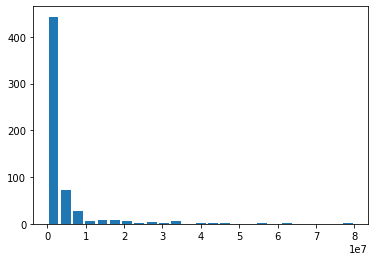

In [ ]:
# Read the csv file, get a list of the popularity column and calculate bins
num_bins = 25
followers_list = list(artists_df['followers'])
bin_values = myhistogram(val_list, num_bins)

#Use matplotlib to show the graph
bins = num_bins
interval = (max(followers_list) - min(followers_list)) / num_bins
x_values = [min(followers_list) + (i * interval) + interval/2 for i in range(bins)]
pyplot.bar(x_values, bin_values, width=(0.8 * interval))
pyplot.show()

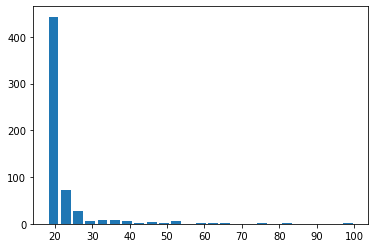

In [ ]:
# Read the csv file, get a list of the popularity column and calculate bins
num_bins = 25
pop_list = list(artists_df['pop'])
bin_values = myhistogram(val_list1, num_bins)

#Use matplotlib to show the graph
bins = num_bins
interval = (max(pop_list) - min(pop_list)) / num_bins
x_values = [min(pop_list) + (i * interval) + interval/2 for i in range(bins)]
pyplot.bar(x_values, bin_values, width=(0.8 * interval))
pyplot.show()

**Interpretation**: The two histograms both show that most of the artists have a small number of followers and a low rate of popularity. The higher number of followers or rate of popularity, the fewer artists appear. We also notice that the distributions of the two variables are quite similar, suggesting that there might be a relationship between those two. We would continue to look into this in the next part: data analysis. 

### Billboard
In terms of the Billboard's data, we will construct one histogram of the Number of weeks on "Hot 100" chart variable to gain insights into its distribution. 

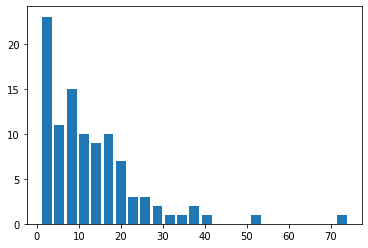

In [ ]:
# Read the csv file, get a list of the popularity column and calculate bins
num_bins = 25
df = pd.read_csv("hot100.csv")
val_list = list(df['Weeks On Chart'])
bin_values = myhistogram(val_list, num_bins)

#Use matplotlib to show the graph
bins = num_bins
interval = (max(val_list) - min(val_list)) / num_bins
x_values = [min(val_list) + (i * interval) + interval/2 for i in range(bins)]
pyplot.bar(x_values, bin_values, width=(0.8 * interval))
pyplot.show()